In [4]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install joblib
# %pip install pennylane
# %pip install pandas
# %pip install seaborn
# %pip install imblearn

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.svm import SVC
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.algorithms import QSVC
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from torchvision import transforms
from joblib import Parallel, delayed
import pennylane as qml

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths

In [4]:
train_path_norm = f'{path}/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/test/PNEUMONIA'

#### Count files in directory

In [5]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

In [6]:
print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

Length train_path_norm: 1341
Length train_path_pneu: 3875
Length test_path_norm: 234
Length test_path_pneu: 390


#### Check data

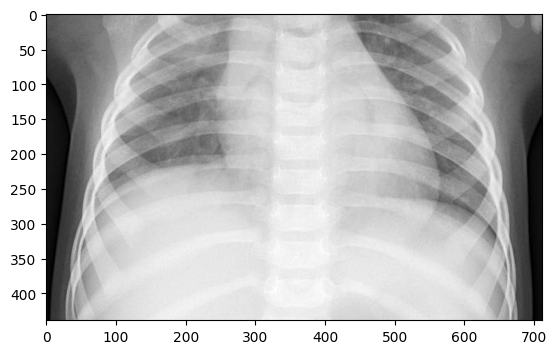

In [7]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

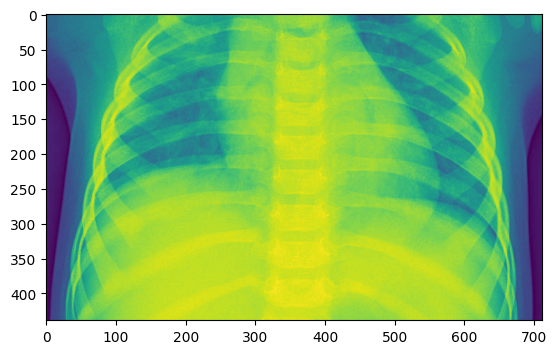

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [9]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            # Load image, resize, and convert to RGB
            img = Image.open(img_path).convert("RGB").resize(target_size)
            # Convert to numpy array and flatten
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


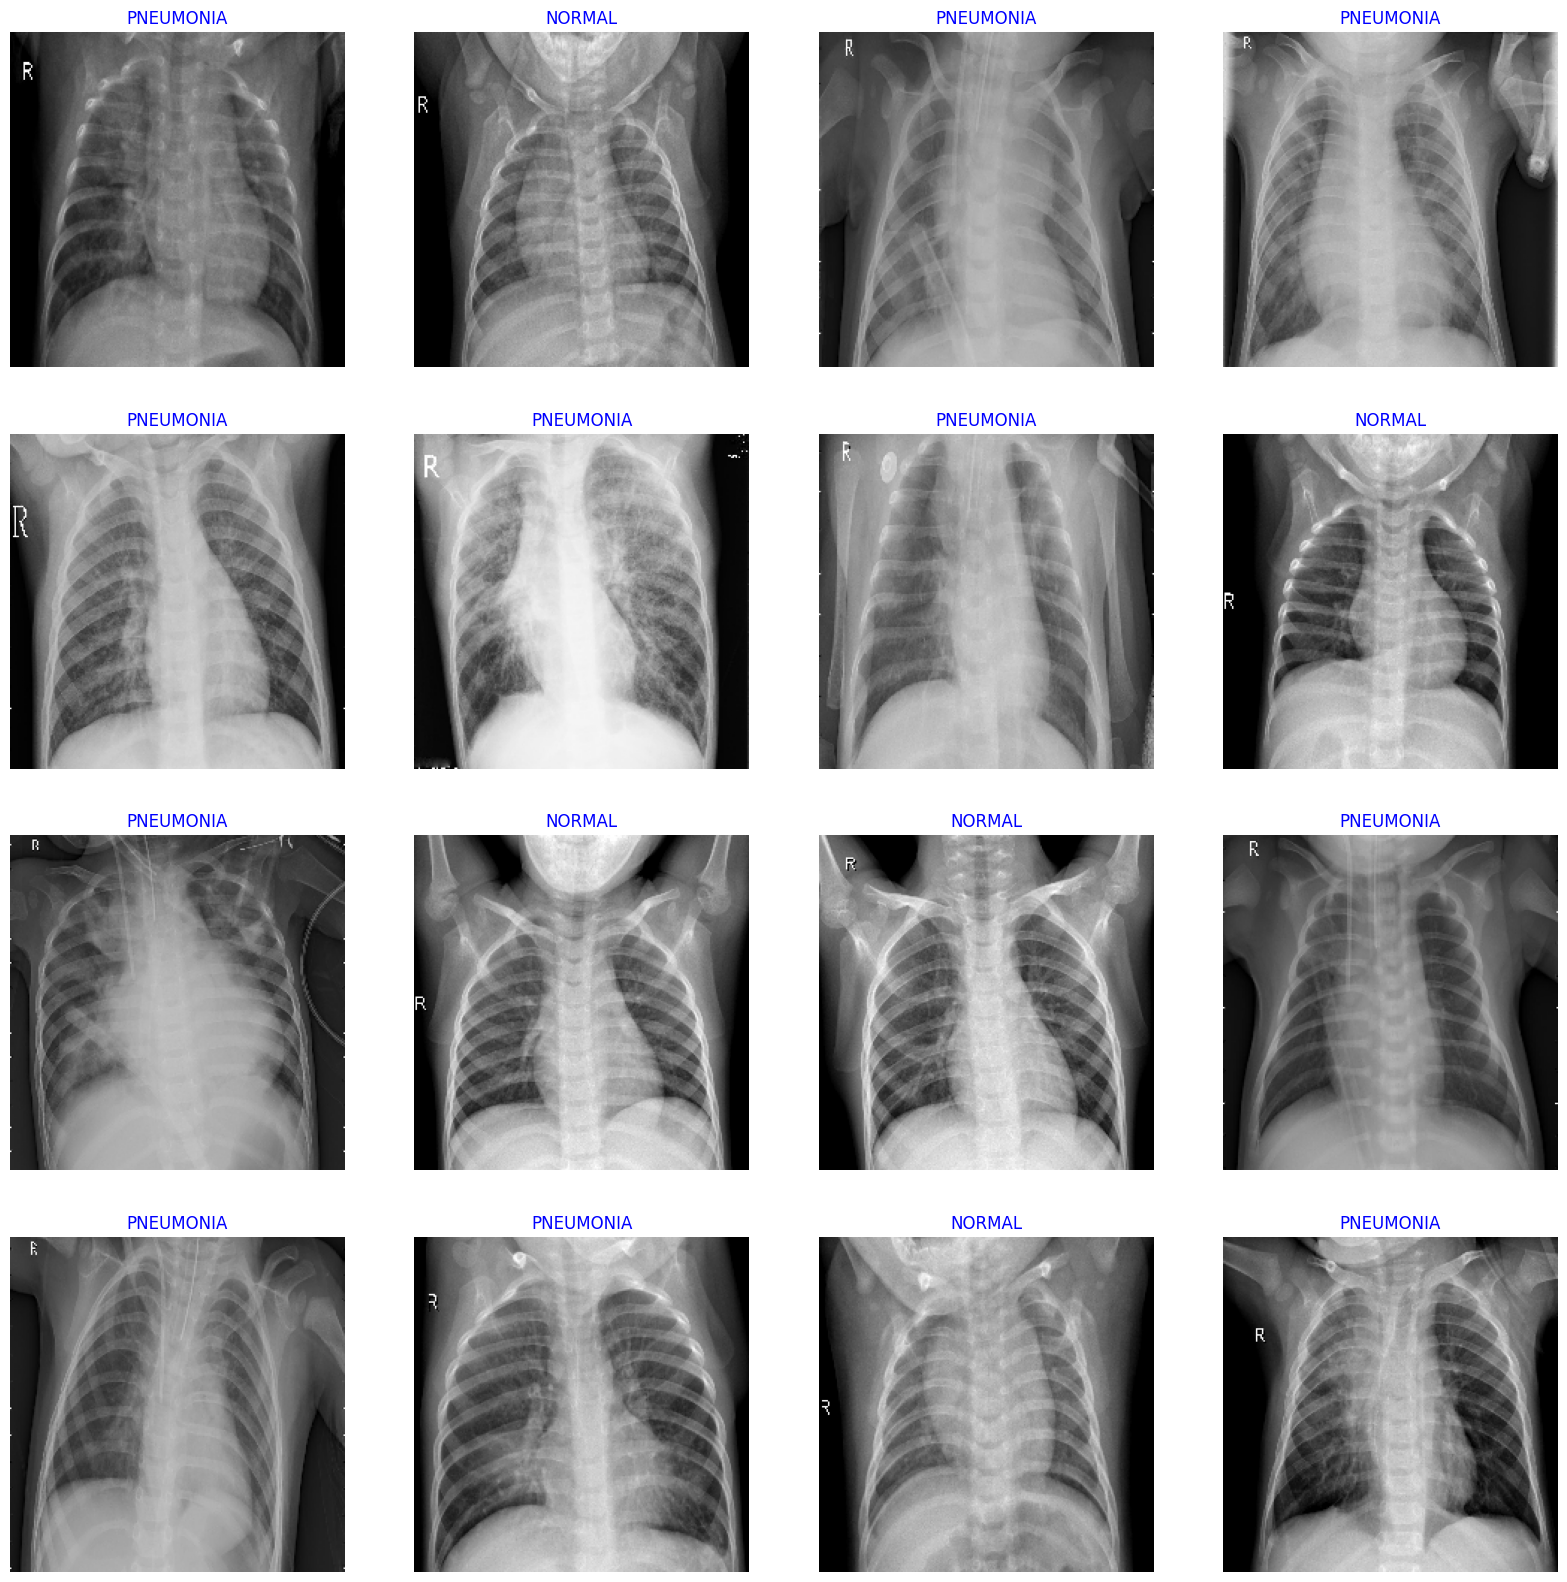

In [10]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Proportional sampling for balanced dataset

In [11]:
num_samples = 300
num_samples_test = 60

norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)

num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)

num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

#### Load data with a smaller sample size for fit

In [12]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

#### PCA for dimensionality reduction & Apply SMOTE for oversampling

In [13]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)

smote = SMOTE()
X_train_pca, y_train = smote.fit_resample(X_train_pca, y_train)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

#### Load and prepare test data

In [14]:
test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)
X_test_pca = pca.transform(X_test)

#### Display the categorized file paths and labels

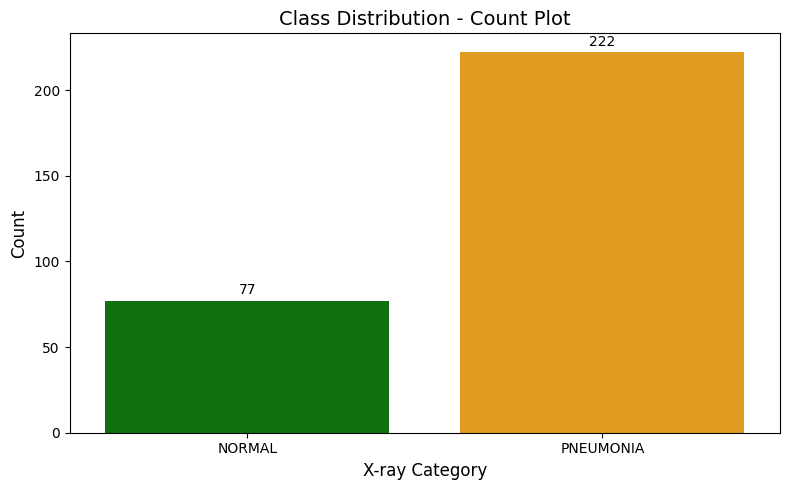

In [15]:
file_paths = train_data_norm + train_data_pneu
labels = train_labels_norm + train_labels_pneu

df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'PNEUMONIA' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'PNEUMONIA': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Plot the data

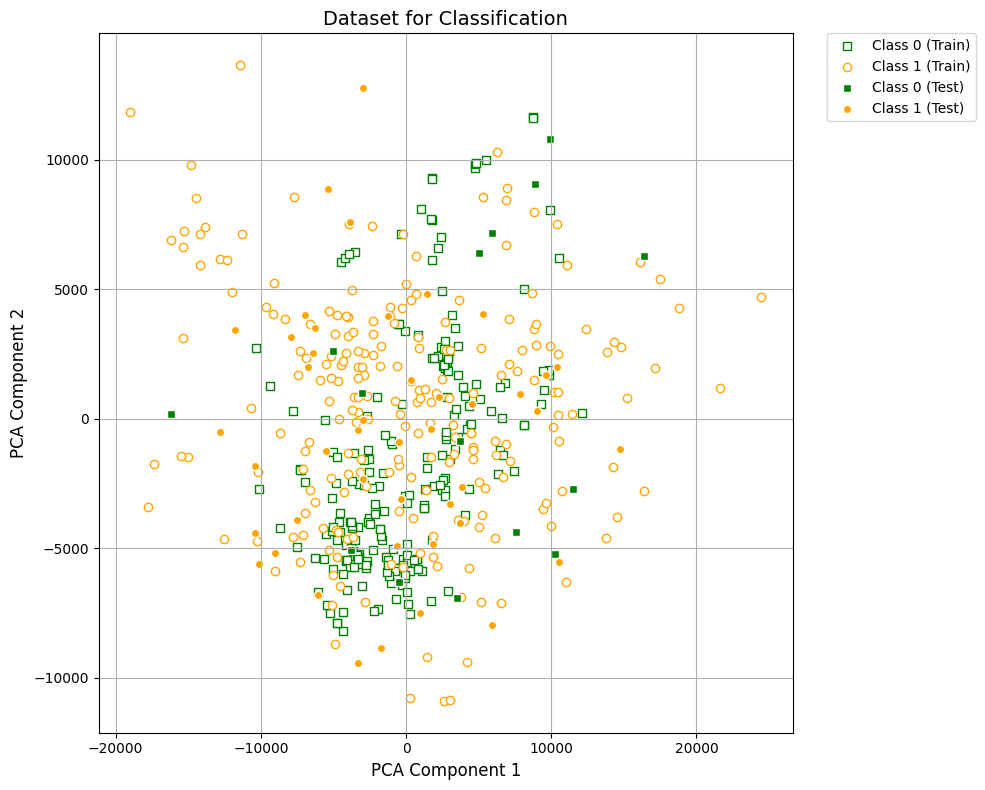

In [16]:
plt.figure(figsize=(10, 8))

plt.scatter(
    X_train_tensor[np.where(y_train_tensor == 0)[0], 0].numpy(),
    X_train_tensor[np.where(y_train_tensor == 0)[0], 1].numpy(),
    marker="s",
    facecolors="w",
    edgecolors="green",
    label="Class 0 (Train)",
)

plt.scatter(
    X_train_tensor[np.where(y_train_tensor == 1)[0], 0].numpy(),
    X_train_tensor[np.where(y_train_tensor == 1)[0], 1].numpy(),
    marker="o",
    facecolors="w",
    edgecolors="orange",
    label="Class 1 (Train)",
)

plt.scatter(
    X_test_pca[np.where(y_test == 0)[0], 0],
    X_test_pca[np.where(y_test == 0)[0], 1],
    marker="s",
    facecolors="green",
    edgecolors="w",
    label="Class 0 (Test)",
)

plt.scatter(
    X_test_pca[np.where(y_test == 1)[0], 0],
    X_test_pca[np.where(y_test == 1)[0], 1],
    marker="o",
    facecolors="orange",
    edgecolors="w",
    label="Class 1 (Test)",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset for Classification", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Setup the quantum device and number of qubits

In [16]:
n_qubits = X_train_tensor.shape[1]
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

#### Feature map

In [17]:
def feature_map(x):
    if isinstance(x, (float, np.float32, np.float64)):
        x = [x]
    for i, val in enumerate(x):
        qml.RX(val, wires=i)

#### Kernel circuit

In [18]:
@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.expval(qml.Projector([0] * n_qubits, wires=range(n_qubits)))

#### Compute a row of the kernel matrix

In [19]:
def compute_kernel_row(i, X1, X2):
    return [kernel_circuit(X1[i], X2[j]) for j in range(X2.shape[0])]

#### Compute the quantum kernel in parallel

In [20]:
def quantum_kernel_parallel(X1, X2, n_jobs=-1):
    m1 = X1.shape[0]
    rows = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(compute_kernel_row)(i, X1, X2) for i in range(m1)
    )
    return np.array(rows)

#### Ensure tensors are 2D for compatibility

In [21]:
if len(X_train_tensor.shape) == 1:
    X_train_tensor = X_train_tensor.unsqueeze(1)
if len(y_train_tensor.shape) == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)

#### Calculate the kernel matrix

In [22]:
K_train_parallel = quantum_kernel_parallel(
    X_train_tensor.numpy(), y_train_tensor.numpy(), n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [23]:
with open('kernels/K_train_parallel_custom.pkl', 'wb') as f:
    pickle.dump(K_train_parallel, f)

In [22]:
with open('kernels/K_train_parallel_custom.pkl', 'rb') as f:
    loaded_kernel = pickle.load(f)

In [18]:
matrix_train = np.dot(X_train_tensor, X_train_tensor.T)
matrix_test = np.dot(X_test_pca, X_train_tensor.T)

In [ ]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [24]:
svc = SVC(kernel="precomputed")
svc.fit(matrix_train, y_train)
score_precomputed_kernel = svc.score(matrix_test, y_test)
print(f"Precomputed kernel classification test score: {score_precomputed_kernel}")

Precomputed kernel classification test score: 0.7457627118644068


In [28]:
qsvc = SVC(kernel="precomputed")
qsvc.fit(matrix_train, y_train)
qsvc_score = qsvc.score(matrix_test, y_test)
print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.7457627118644068


In [30]:
print(f"Classification Model                    | Accuracy Score")
print(f"--------------------------------------------------------")
print(f"SVC using precomputed kernel matrix     | {score_precomputed_kernel: 10.2f}")
print(f"QSVC                                    | {qsvc_score: 10.2f}")

Classification Model                    | Accuracy Score
--------------------------------------------------------
SVC using precomputed kernel matrix     |       0.75
QSVC                                    |       0.75


#### Compute evaluation metrics

In [32]:
y_pred = svc.predict(matrix_test)

In [34]:
classification_rep = metrics.classification_report(y_test, y_pred, output_dict=True)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, qsvc.decision_function(matrix_test))

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report: {'0': {'precision': 0.5, 'recall': 0.5333333333333333, 'f1-score': 0.5161290322580645, 'support': 15.0}, '1': {'precision': 0.8372093023255814, 'recall': 0.8181818181818182, 'f1-score': 0.8275862068965517, 'support': 44.0}, 'accuracy': 0.7457627118644068, 'macro avg': {'precision': 0.6686046511627908, 'recall': 0.6757575757575758, 'f1-score': 0.671857619577308, 'support': 59.0}, 'weighted avg': {'precision': 0.7514781237682302, 'recall': 0.7457627118644068, 'f1-score': 0.7484021794460889, 'support': 59.0}}
Confusion Matrix:
 [[ 8  7]
 [ 8 36]]
ROC AUC Score: 0.8196969696969697


#### Plot the confusion matrix

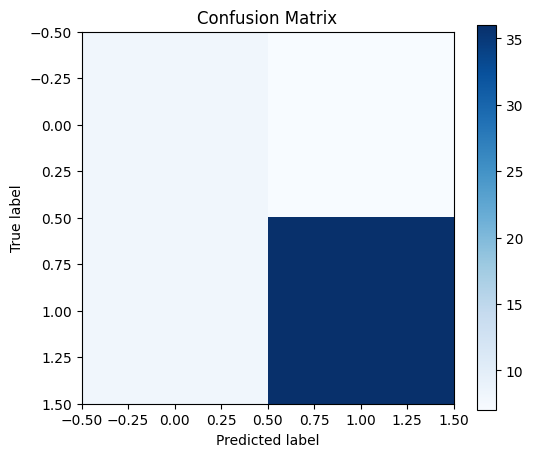

In [35]:
plt.figure(figsize=(6, 5))
plt.title("Confusion Matrix")
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

#### Plot the ROC curve

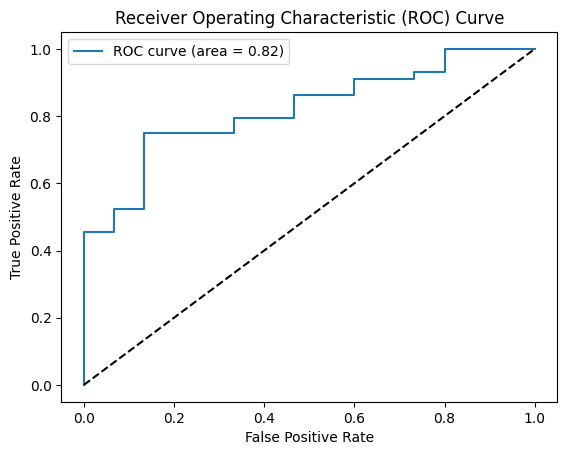

In [38]:
fpr, tpr, _ = metrics.roc_curve(y_test, qsvc.decision_function(matrix_test))
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.show()

In [41]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright